In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### imports

In [122]:
print(__doc__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

Automatically created module for IPython interactive environment


### utilities

In [3]:
def sigmoid(x):
    return 1 / (1 + (np.e**-x))

### load dataset

In [71]:
# total number of samples needed
datasize = 100

# retrieve dataset
docs = fetch_20newsgroups(subset='train', shuffle=False, remove=('headers', 'footers', 'quotes'))
docs, old_labels, classes = docs.data[:datasize], docs.target[:datasize], docs.target_names

In [72]:
# the actual labels as np array
old_labels = np.array(old_labels)
labels = np.zeros(old_labels.shape, dtype=int)

# the new classes
label_classes = list(set([x.split('.')[0] for x in classes]))

# restructuring classes  from 19 to less
for label, cl in enumerate(classes):
    labels[old_labels == label] = label_classes.index(cl.split('.')[0])

In [73]:
print(f"there are {len(docs)} docs and {len(label_classes)} classes: {label_classes}")

there are 100 docs and 7 classes: ['sci', 'soc', 'misc', 'rec', 'alt', 'comp', 'talk']


### clean dataset

In [74]:
# clean out the new line characters from text in docs
def clean_doc(doc):
    ''' remove unwanter characters line new line '''

    unwanted_chrs = [')', '(', '{', '}', '\t', '\n', '\r', "'", '"', "!"]
    for unwanted_chr in unwanted_chrs:
        doc = doc.replace(unwanted_chr, ' ')

    return doc.strip()

clean_docs = [clean_doc(doc) for doc in docs]
clean_docs[0]

'morgan and guzman will have era s 1 run higher than last year, and  the cubs will be idiots and not pitch harkey as much as hibbard.  castillo won t be good  i think he s a stud pitcher'

### count words

In [75]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()
# count_vectorizer = TfidfVectorizer()

# fit it to dataset
count_vectorizer.fit(clean_docs)

words = count_vectorizer.get_feature_names()

print("word_count is", len(words))

word_count is 5550


### Prepare Datatset

In [76]:
# create doc count vectors
doc_vectors = count_vectorizer.transform(clean_docs).toarray()



train_doc_vectors, test_doc_vectors, train_labels, test_labels = train_test_split(doc_vectors, labels, test_size=.33, random_state=42)
print(f"{len(train_labels)} train_docs, {len(test_labels)} test docs")

67 train_docs, 33 test docs


In [77]:
document_word_frequency = pd.DataFrame(train_doc_vectors, columns=count_vectorizer.get_feature_names())
document_word_binary_frequency = (document_word_frequency > 0).astype('int')

document_word_frequency["__labels__"] = train_labels
document_word_binary_frequency["__labels__"] = train_labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (67, 5551)


In [78]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 100 docs and 7 classes


In [79]:
document_word_frequency.head()

,00,000,0188,02026,04110,0837,0988,0q,0qax,0qq,...,z6e1,z6e1t,z6ei,zealand,zeh,zip,zirconium,zone,zoomed,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
document_word_binary_frequency.head()

,00,000,0188,02026,04110,0837,0988,0q,0qax,0qq,...,z6e1,z6e1t,z6ei,zealand,zeh,zip,zirconium,zone,zoomed,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Prepare Binary Dataset

In [81]:
#reduce freq in doc to bin value of 1 or 0
word_doc_binary_freqency = document_word_binary_frequency.drop(["__labels__"], axis='columns')

#the sum vertically of bin freq
word_doc_frequency = word_doc_binary_freqency.sum(0) 

### Topic and word corelation

In [82]:
topic_word_distr = pd.DataFrame(data=0.0, columns=label_classes, index=words)

for topic, label in enumerate(label_classes):
    word_topic_frequency = word_doc_binary_freqency[document_word_frequency['__labels__'] == topic].sum(0)
    trust_factor = sigmoid(word_doc_frequency)
    
    topic_word_distr[label] = ((word_topic_frequency * trust_factor) / word_doc_frequency).fillna(0)
    
print(f"topic_word_distr has shape {topic_word_distr.shape}")

topic_word_distr has shape (5550, 7)


In [83]:
topic_word_distr.head()

,sci,soc,misc,rec,alt,comp,talk
00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
000,0.440399,0.0,0.0,0.0,0.0,0.0,0.440399
0188,0.731059,0.0,0.0,0.0,0.0,0.0,0.000000
02026,0.731059,0.0,0.0,0.0,0.0,0.0,0.000000
04110,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [84]:
label_classes

['sci', 'soc', 'misc', 'rec', 'alt', 'comp', 'talk']

In [85]:
label_class = 'comp'
topic_word_distr[label_class][topic_word_distr[label_class] > 0].sort_values(ascending=False)

windows    0.997527
problem    0.997527
bit        0.982014
advance    0.982014
change     0.982014
             ...   
around     0.111097
here       0.099995
most       0.083333
we         0.083333
just       0.083333
Name: comp, Length: 1365, dtype: float64

In [86]:
topic_word_distr.loc["the"]

sci     0.272727
soc     0.036364
misc    0.054545
rec     0.145455
alt     0.054545
comp    0.345455
talk    0.090909
Name: the, dtype: float64

### Word word corelation

In [87]:
word_word_distr = pd.DataFrame(data=0.0, columns=words, index=words)

for word in tqdm(words):
    word_word_frequency = word_doc_binary_freqency[word_doc_binary_freqency[word] > 0].sum(0)
    trust_factor = sigmoid(word_doc_frequency)

    word_word_co = ((word_word_frequency * trust_factor) / word_doc_frequency).fillna(0)
    word_word_distr[word][word_word_co > word_word_distr[word]] = word_word_co[word_word_co > word_word_distr[word]]

word_word_distr = word_word_distr.T
print("word_word_distr has shape", word_word_distr.shape)


word_word_distr has shape (5550, 5550)


In [88]:
word_word_distr.head()

,00,000,0188,02026,04110,0837,0988,0q,0qax,0qq,...,z5,z6e1,z6e1t,z6ei,zealand,zeh,zip,zirconium,zone,zoomed
00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
000,0.0,0.880797,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
0188,0.0,0.000000,0.731059,0.731059,0.0,0.731059,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.440399,0.0,0.0,0.0
02026,0.0,0.000000,0.731059,0.731059,0.0,0.731059,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.440399,0.0,0.0,0.0
04110,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [89]:
word = "the"
word_word_distr[word][word_word_distr[word] > .5].sort_values(ascending=False)

the     1.000000
to      0.872727
of      0.836364
in      0.763636
and     0.727273
is      0.672727
it      0.618182
that    0.581818
on      0.581818
for     0.581818
but     0.581818
with    0.545455
if      0.527273
have    0.527273
not     0.509091
be      0.509091
Name: the, dtype: float64

### Building topic model

In [90]:
re_topic_word_distr = topic_word_distr.copy()

for word in tqdm(words):
    word_word_co = word_word_distr[word]
    
    for label_class in label_classes:
        infered_ratio = (word_word_co * topic_word_distr[label_class]).max()
        
        if infered_ratio > re_topic_word_distr[label_class][word]:
            re_topic_word_distr[label_class][word] = infered_ratio
            
print("re_topic_word_distr has shape", re_topic_word_distr.shape)


re_topic_word_distr has shape (5550, 7)


In [91]:
re_topic_word_distr.head()

,sci,soc,misc,rec,alt,comp,talk
00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
000,0.559350,0.279675,0.193951,0.279675,0.279675,0.524941,0.440399
0188,0.731059,0.321957,0.321957,0.464258,0.321957,0.538432,0.464258
02026,0.731059,0.321957,0.321957,0.464258,0.321957,0.538432,0.464258
04110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [103]:
word = "companies"
re_topic_word_distr.loc[word].sort_values(ascending=False)

sci     0.731059
comp    0.487369
talk    0.364625
misc    0.358955
alt     0.321957
rec     0.321957
soc     0.232129
Name: companies, dtype: float64

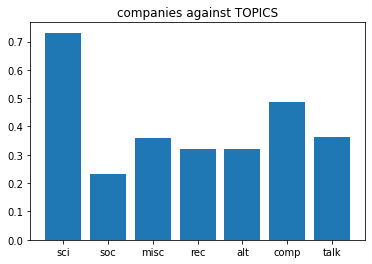

In [93]:
plt.title(f"{word} against TOPICS")
plt.bar(re_topic_word_distr.loc[word].index, re_topic_word_distr.loc[word])
plt.show()

### Evaluating Topic Model

In [120]:
score = 0
print("Evaluating Topic Model...")
for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr = re_topic_word_distr.copy()
    doc_word_freq_norm = (doc_vector > 0).astype(int)
#     doc_word_freq_norm = doc_vector / doc_vector.sum() if doc_vector.sum() else 0

    for label_class in label_classes:
        doc_topic_word_distr[label_class] *= doc_word_freq_norm
    
    doc_topic = np.max(doc_topic_word_distr).idxmax()
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if score:
        continue
    
#     print(clean_docs[len(train_labels)+doc_index])
#     print("{:8s} {:16s} {:6s}".format("topic", "word", "relation"))
#     print("="*40)
#     for label, word in doc_topic_word_distr.idxmax().items():
#         print("{:8s} {:16s} {:.4f}".format(label, word, doc_topic_word_distr[label][word]))

#     print(f"\nthe topic predicted is ==> '{np.max(doc_topic_word_distr).idxmax()}'")
#     print(f"the actual topic is ==> '{label_classes[labels[doc_index]]}'")

accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {accuracy*100:.2f}%\n")

Evaluating Topic Model...



==> test-accuracy is 88.06%



### Testing Topic Model

In [121]:
score = 0
print("Evaluating Topic Model...")
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr = re_topic_word_distr.copy()
    doc_word_freq_norm = (doc_vector > 0).astype(int)
#     doc_word_freq_norm = doc_vector / doc_vector.sum() if doc_vector.sum() else 0

    for label_class in label_classes:
        doc_topic_word_distr[label_class] *= doc_word_freq_norm
    
    doc_topic = np.max(doc_topic_word_distr).idxmax()
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if score:
        continue
    
#     print(clean_docs[len(train_labels)+doc_index])
#     print("{:8s} {:16s} {:6s}".format("topic", "word", "relation"))
#     print("="*40)
#     for label, word in doc_topic_word_distr.idxmax().items():
#         print("{:8s} {:16s} {:.4f}".format(label, word, doc_topic_word_distr[label][word]))

#     print(f"\nthe topic predicted is ==> '{np.max(doc_topic_word_distr).idxmax()}'")
#     print(f"the actual topic is ==> '{label_classes[labels[doc_index]]}'")

accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {accuracy*100:.2f}%\n")

Evaluating Topic Model...



==> test-accuracy is 36.36%



In [123]:
label_classes

['sci', 'soc', 'misc', 'rec', 'alt', 'comp', 'talk']

In [131]:
from sklearn.linear_model import LogisticRegression

X = np.nan_to_num(train_doc_vectors / train_doc_vectors.sum(0))
y = (train_labels == 5).astype(int)

clf = LogisticRegression(random_state=0).fit(X, y)


c:\users\christian\documents\christian\work\python\cyberspace\semantic_segmentation\venv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [132]:
len(X)

67

In [133]:
clf.predict(X[-1:])

array([0])

In [136]:
clf.predict_proba(X[-1:]), y[-1:]

(array([[0.94751738, 0.05248262]]), array([0]))

In [135]:
clf.score(X, y)

0.9701492537313433

In [141]:
XX = np.nan_to_num(test_doc_vectors / test_doc_vectors.sum(0))
yy = (test_labels == 5).astype(int)

clf.score(XX, yy)

c:\users\christian\documents\christian\work\python\cyberspace\semantic_segmentation\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


0.7878787878787878

In [142]:
len(test_labels), len(yy)

(33, 33)

In [99]:
# word_word_distr.to_clipboard(f"word_word_distr_{datasize}.csv")
# topic_word_distr.to_csv(f"topic_word_distr_{datasize}.csv")
# re_topic_word_distr.to_csv(f"re_topic_word_distr_{datasize}.csv")